In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to your code
%cd /content/drive/MyDrive/addition
%pwd   # verify you’re in the right place
!ls    # should show train.py, 4_operands_addition.txt, etc.

Mounted at /content/drive
/content/drive/MyDrive/addition
2_operands_0_to_999_balanced_digit
2_operands_addition.txt
3_operands_addition.txt
4_operands_0_to_999_addition_not_reversed
4_operands_0_to_999_addition_not_reversed_NoPE
4_operands_0_to_999_addition_reversed
4_operands_3_digits_addition_not_reversed_1M_additional_metric
4_operands_3_digits_addition_not_reversed_1M_lr_adjusted
4_operands_3_digits_addition_reversed_1M
4_operands_4_digits_addition_reversed
4_operands_addition_3_digit.txt
4_operands_addition_not_reversed.txt
4_operands_addition_reversed.txt
5_operands_addition.txt
6_operands_addition.txt
7_operands_addition.txt
ckpt_iter_145100_acc.pt
configurator.py
data
eight_operand_examples.txt
evaluation.py
generate_addition_data.py
main_utilities.py
model.py
myStart_New.ipynb
original.txt
__pycache__
README.md
reverse_4_addition_2000
reversed_new.txt
reversed.txt
simple_test.ipynb
test_checkpoint.ipynb
train_NoPE.py
train.py
train_zero_padding_NoPE.py
train_zero_padding.py
t

In [3]:
%cd /content/drive/MyDrive/addition/data
%pwd   # verify you’re in the right place
!ls    # should show train.py, 4_operands_addition.txt, etc.

/content/drive/MyDrive/addition/data
addition_2_operands_0_to_999_balanced_digit  create_data.py
addition_4_operands_0_to_999		     data_generation.ipynb
addition_4_operands_1_digit		     data_utilities.py
addition_4_operands_3_digit		     generate_0_to_999.py
addition_4_operands_4_digit		     reverse_results.py
create_data_multiple_operators.py	     sample_and_strip.py


In [ ]:
!python reverse_results.py

Processed './4_operands_0_to_999_10K_val.txt' and wrote results to './4_operands_0_to_999_10K_val_reversed.txt'.


## Generate 4 Operand 4 Digit Data

Create training, valuation and testing data.

In [ ]:
import random
from pathlib import Path

def generate_dataset(num_samples: int,
                     output_path: Path,
                     include_answer: bool = True,
                     append_dollar: bool = False):
    """
    Generates lines of the form:
      a+b+c+d=SUM$
    or
      a+b+c+d=\n
    where a, b, c, d are random 4-digit integers.

    Parameters:
    - num_samples: Number of lines to generate.
    - output_path: Path to save the generated file.
    - include_answer: If True, include the sum after '='.
    - append_dollar: If True, append a dollar sign after the sum.
    """
    lines = []
    for _ in range(num_samples):
        # keep sampling until we get a 5-digit sum
        while True:
            ops = [random.randint(1000, 9999) for _ in range(4)]
            total = sum(ops)
            if 10000 <= total <= 99999:
                break

        expr = "+".join(map(str, ops)) + "="
        if include_answer:
            expr += str(total)
            if append_dollar:
                expr += "$"
        lines.append(expr + "\n")


    # Make sure the directory exists
    output_path.parent.mkdir(parents=True, exist_ok=True)
    # Write all lines at once
    output_path.write_text("".join(lines))


if __name__ == "__main__":
    # 1 million training examples, with sums and a trailing '$'
    generate_dataset(
        num_samples=1_000_000,
        output_path=Path("/content/drive/MyDrive/addition/data/4_operands_4_digits_1M_train.txt"),
        include_answer=True,
        append_dollar=True
    )

    # 10 000 validation examples, with sums and a trailing '$'
    generate_dataset(
        num_samples=10_000,
        output_path=Path("/content/drive/MyDrive/addition/data/4_operands_4_digits_10K_val.txt"),
        include_answer=True,
        append_dollar=True
    )

    # 10 000 test examples, without the sums (just the '=')
    generate_dataset(
        num_samples=10_000,
        output_path=Path("/content/drive/MyDrive/addition/data/4_operands_4_digits_10K_test.txt"),
        include_answer=False
    )


Create training evaluation data. (Randomly sample 10K from training data and strip the result)

In [ ]:
!python sample_and_strip.py \
    --input ./addition_4_operands_4_digit/4_operands_4_digits_1M_train.txt \
    --output ./addition_4_operands_4_digit/4_operands_4_digits_10K_train_eval.txt \
    --sample-size 10000

Total lines in input file: 1000000
Wrote 10000 sampled lines to './addition_4_operands_4_digit/4_operands_4_digits_10K_train_eval.txt'.


In [ ]:
%pwd

'/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/data'

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_53140/3235429647.py:14: DtypeWarning: Columns (36,38,57,59,62,64,65,66,67,68,69,71,72,73,78,81,83,86,89,90,93,97,98,99,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


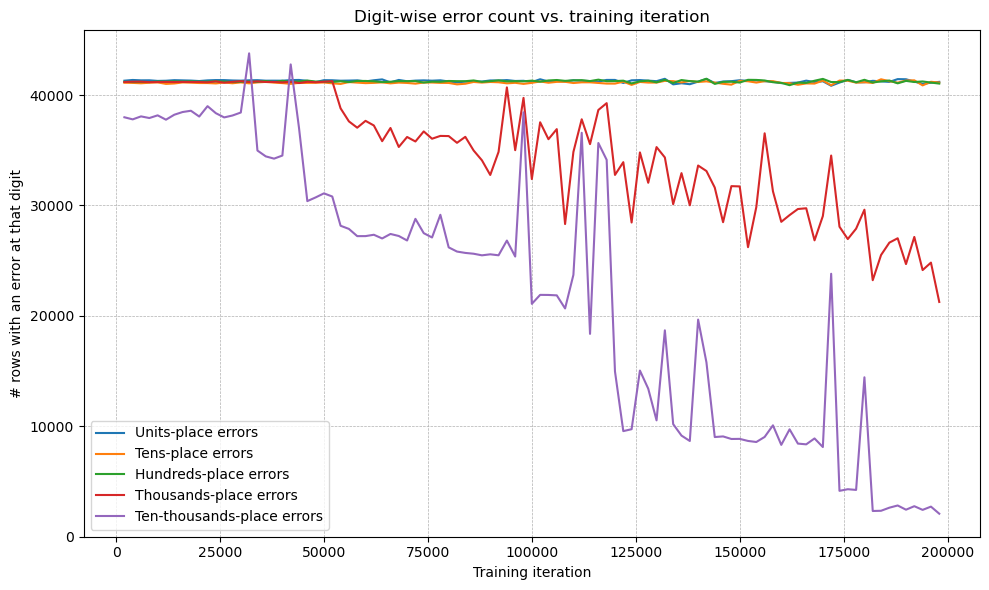

In [ ]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path("/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/4_operands_4_digits_addition_reversed/out/4_operands_4_digits_addition_reversed/4_operands_4_digits_10K_test_results.csv")   # <-- your single big file
STEP_SIZE  = 100
OFFSET     = 100                       # ← new: first iteration to plot
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actual, pred) -> dict[str, int]:
    """Return dict with counts of errors by decimal place (units … thousands)."""
    counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0, "ten_thousands": 0}
    for gold, guess in zip(actual, pred):
        # defensive parsing – treat blanks / non-ints as all-digit errors
        try:
            g = str(int(gold)).zfill(5)
            p = str(int(guess)).zfill(5)
        except ValueError:
            g = str(int(gold)).zfill(5)
            p = "00000"
        if g[-1] != p[-1]:
            counts["units"] += 1
        if g[-2] != p[-2]:
            counts["tens"] += 1
        if g[-3] != p[-3]:
            counts["hundreds"] += 1
        if g[-4] != p[-4]:
            counts["thousands"] += 1
        if g[-5] != p[-5]:
            counts["ten_thousands"] += 1
    return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────
iterations, units, tens, hundreds, thousands, ten_thousands = [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    ten_thousands.append(stats["ten_thousands"])

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Generate Flexible 3 Digit Data (0-999)

In [ ]:
import random
from pathlib import Path

def generate_dataset(num_samples: int,
                     output_path: Path,
                     include_answer: bool = True,
                     append_dollar: bool = False):
    """
    Generates lines of the form:
      a+b+c+d=SUM$
    or
      a+b+c+d=\n
    where a, b, c, d are random 3-digit integers, ranging from 0 to 999.

    Parameters:
    - num_samples: Number of lines to generate.
    - output_path: Path to save the generated file.
    - include_answer: If True, include the sum after '='.
    - append_dollar: If True, append a dollar sign after the sum.
    """
    lines = []
    for _ in range(num_samples):
        ops = [random.randint(0, 999) for _ in range(4)]
        total = sum(ops)


        expr = "+".join(map(str, ops)) + "="
        if include_answer:
            expr += str(total)
            if append_dollar:
                expr += "$"
        lines.append(expr + "\n")


    # Make sure the directory exists
    output_path.parent.mkdir(parents=True, exist_ok=True)
    # Write all lines at once
    output_path.write_text("".join(lines))


if __name__ == "__main__":
    # 1 million training examples, with sums and a trailing '$'
    generate_dataset(
        num_samples=1_000_000,
        output_path=Path("/content/drive/MyDrive/addition/data/4_operands_0_to_999_1M_train.txt"),
        include_answer=True,
        append_dollar=True
    )

    # 10 000 validation examples, with sums and a trailing '$'
    generate_dataset(
        num_samples=10_000,
        output_path=Path("/content/drive/MyDrive/addition/data/4_operands_0_to_999_10K_val.txt"),
        include_answer=True,
        append_dollar=True
    )

    # 10 000 test examples, without the sums (just the '=')
    generate_dataset(
        num_samples=10_000,
        output_path=Path("/content/drive/MyDrive/addition/data/4_operands_0_to_999_10K_test.txt"),
        include_answer=False
    )


In [ ]:
!python sample_and_strip.py \
    --input ./4_operands_0_to_999_1M_train.txt \
    --output ./4_operands_0_to_999_1M_train_eval.txt \
    --sample-size 10000

Total lines in input file: 1000000
Wrote 10000 sampled lines to './4_operands_0_to_999_1M_train_eval.txt'.


[(0, 'pred_iter_0'), (250, 'pred_iter_250'), (500, 'pred_iter_500'), (750, 'pred_iter_750'), (1000, 'pred_iter_1000'), (1250, 'pred_iter_1250'), (1500, 'pred_iter_1500'), (1750, 'pred_iter_1750'), (2000, 'pred_iter_2000'), (2250, 'pred_iter_2250'), (2500, 'pred_iter_2500'), (2750, 'pred_iter_2750'), (3000, 'pred_iter_3000'), (3250, 'pred_iter_3250'), (3500, 'pred_iter_3500'), (3750, 'pred_iter_3750'), (4000, 'pred_iter_4000'), (4250, 'pred_iter_4250'), (4500, 'pred_iter_4500'), (4750, 'pred_iter_4750'), (5000, 'pred_iter_5000')]


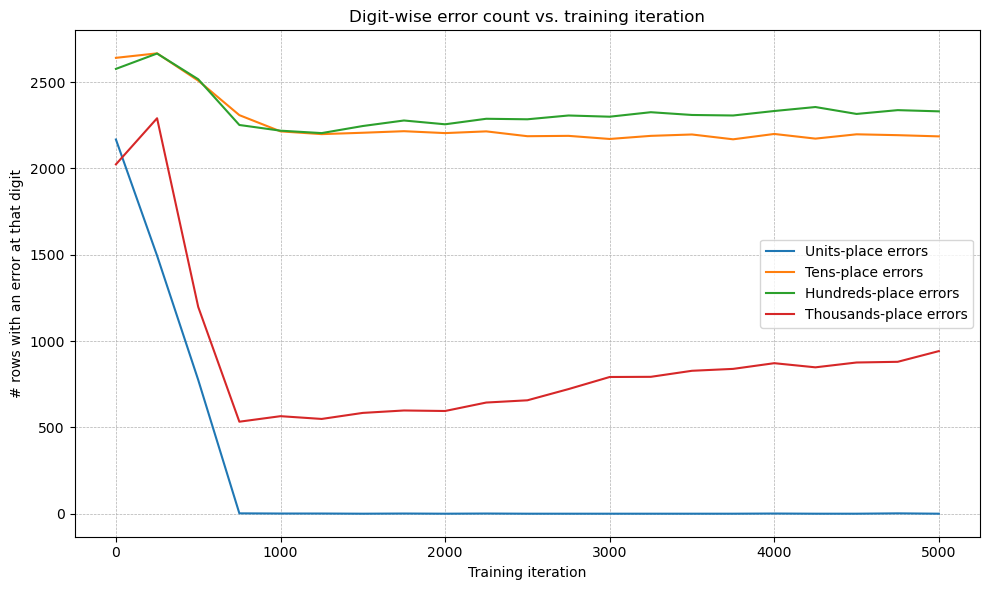

In [24]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/teaching_arithmetic/out2/multiplication_reverse/teaching_multiplication_reverse_1/main_test_file_results.csv')   # <-- your single big file
STEP_SIZE  = 25
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands = [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten_thousands"])

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (25, 'pred_iter_25'), (50, 'pred_iter_50'), (75, 'pred_iter_75'), (100, 'pred_iter_100'), (125, 'pred_iter_125'), (150, 'pred_iter_150'), (175, 'pred_iter_175'), (200, 'pred_iter_200'), (225, 'pred_iter_225'), (250, 'pred_iter_250'), (275, 'pred_iter_275'), (300, 'pred_iter_300'), (325, 'pred_iter_325'), (350, 'pred_iter_350'), (375, 'pred_iter_375'), (400, 'pred_iter_400'), (425, 'pred_iter_425'), (450, 'pred_iter_450'), (475, 'pred_iter_475'), (500, 'pred_iter_500'), (525, 'pred_iter_525'), (550, 'pred_iter_550'), (575, 'pred_iter_575'), (600, 'pred_iter_600'), (625, 'pred_iter_625'), (650, 'pred_iter_650'), (675, 'pred_iter_675'), (700, 'pred_iter_700'), (725, 'pred_iter_725'), (750, 'pred_iter_750'), (775, 'pred_iter_775'), (800, 'pred_iter_800'), (825, 'pred_iter_825'), (850, 'pred_iter_850'), (875, 'pred_iter_875'), (900, 'pred_iter_900'), (925, 'pred_iter_925'), (950, 'pred_iter_950'), (975, 'pred_iter_975'), (1000, 'pred_iter_1000'), (1250, 'pred_iter_1250'

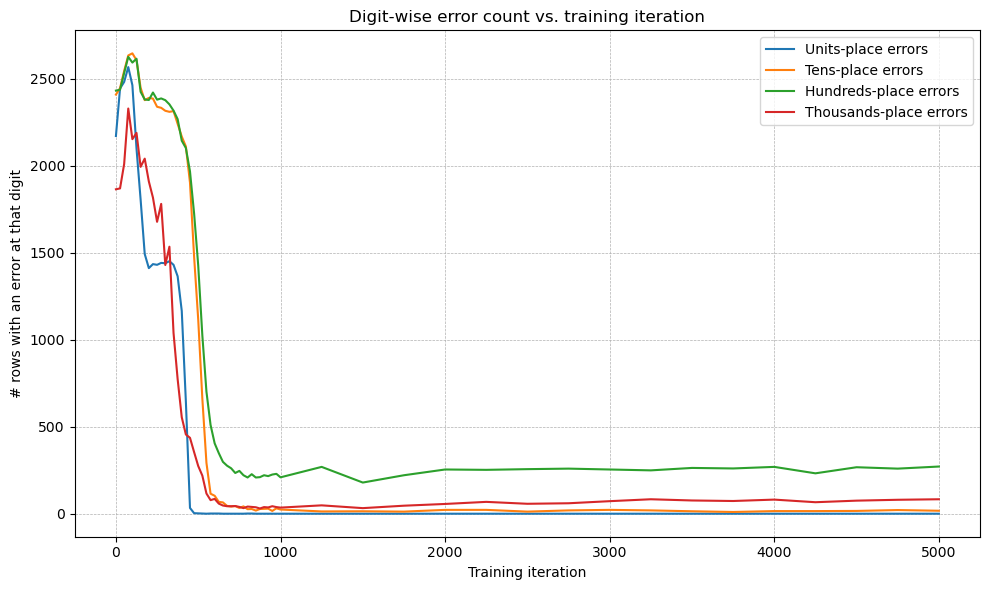

In [29]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/teaching_arithmetic/out2/multiplication_reverse_0_to_999_times_1_digit_bal/reverse_0_to_999_times_1_digit_bal/main_test_file_results.csv')   # <-- your single big file
STEP_SIZE  = 25
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands = [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten_thousands"])

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Reproduce 2 Operands Addition from the paper "Teaching Arithmetic to Small Transformers"

### Generate Data
10K Training: 100 1-digit, 900 2-digit, 9000 3-digit

10K Validation: disjoint from training data, randomly sampled

10K Testing: disjoint from training data, randomly sampled

In [2]:
%ls

addition_2_operands_0_to_999_balanced_digit/
addition_4_operands_0_to_999/
addition_4_operands_1_digit/
addition_4_operands_3_digit/
addition_4_operands_4_digit/
create_data.py
create_data_multiple_operators.py
data_generation.ipynb
data_utilities.py
generate_0_to_999.py
reverse_results.py
sample_and_strip.py


In [3]:
import itertools
import random

def format_with_answer(a, b):
    return f"{a}+{b}={a+b}$"

def format_without_answer(a, b):
    return f"{a}+{b}="

def sample_pairs(pairs, k, seed):
    """Randomly sample k distinct pairs from iterable pairs."""
    return random.Random(seed).sample(pairs, k)

def main():
    random_seed = 42
    random.seed(random_seed)

    # 1) Build training set:
    # 1.1 all 100 1-digit + 1-digit
    ones = list(itertools.product(range(10), repeat=2))

    # 1.2 all 1-digit ↔ 2-digit combos
    one_two = list(itertools.product(range(10), range(10, 100)))
    two_one = [(b, a) for (a, b) in one_two]
    two_two = list(itertools.product(range(10, 100), repeat=2))
    twos = one_two + two_one + two_two

    # 1.3 all 3-digit + 3-digit combos
    # three_three = list(itertools.product(range(100, 1000), repeat=2))
    full_universe = list(itertools.product(range(1000), repeat=2))
    one_and_two = ones + twos
    threes = [p for p in full_universe if p not in one_and_two]

    # sample 900 from mixed_1_2, 9000 from three_three
    sample_1_2 = sample_pairs(twos, 900, seed=random_seed + 1)
    sample_3_3 = sample_pairs(threes, 9000, seed=random_seed + 2)

    train_pairs = ones + sample_1_2 + sample_3_3
    assert len(train_pairs) == 100 + 900 + 9000 == 10000

    # format and shuffle
    train_lines = [format_with_answer(a, b) for (a, b) in train_pairs]
    random.shuffle(train_lines)

    # 2) Build val + test: sample from full universe minus train
    full_universe = list(itertools.product(range(1000), repeat=2))
    train_set = set(train_pairs)

    rest = [p for p in full_universe if p not in train_set]
    # sample without overlap
    val_pairs = sample_pairs(rest, 10000, seed=random_seed + 3)
    rest2 = [p for p in rest if p not in set(val_pairs)]
    test_pairs = sample_pairs(rest2, 10000, seed=random_seed + 4)

    val_lines = [format_with_answer(a, b) for (a, b) in val_pairs]
    random.shuffle(val_lines)
    test_lines = [format_without_answer(a, b) for (a, b) in test_pairs]
    random.shuffle(test_lines)

    # 3) Write out
    with open("train.txt", "w") as f:
        f.write("\n".join(train_lines))
    with open("val.txt", "w") as f:
        f.write("\n".join(val_lines))
    with open("test.txt", "w") as f:
        f.write("\n".join(test_lines))

    print("Generated train.txt, val.txt, test.txt [{} examples each]".format(
        len(train_lines), len(val_lines), len(test_lines)
    ))

if __name__ == "__main__":
    main()


Generated train.txt, val.txt, test.txt [10000 examples each]


Prepare training valuation data

In [5]:
!python sample_and_strip.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 10000

Total lines in input file: 10000
Wrote 10000 sampled lines to './train_eval.txt'.


In [7]:

import os

INPUT_FILENAME = "./train.txt"
OUTPUT_FILENAME = "./train_reversed.txt"

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Processed './train.txt' and wrote results to './train_reversed.txt'.


In [30]:
!python sample_and_strip.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 10000

Total lines in input file: 1000000
Wrote 10000 sampled lines to './train_eval.txt'.


## 4 Operands 0-999 Addition Balanced Digit (1,2,3 digit, each 1/3 chance)

In [25]:
import random
from pathlib import Path

def sample_operand():
    """
    Returns one integer:
      – with probability 1/3 in [0, 9]    (1-digit)
      – with probability 1/3 in [10, 99] (2-digit)
      – with probability 1/3 in [100, 999] (3-digit)
    """
    r = random.random()
    if r < 1/3:
        lo, hi = 0, 9
    elif r < 2/3:
        lo, hi = 10, 99
    else:
        lo, hi = 100, 999
    return random.randint(lo, hi)

seen = set()

def generate_dataset(num_samples: int,
                     output_path: Path,
                     include_answer: bool = True,
                     append_dollar: bool = False):
    lines = []

    while len(lines) < num_samples:
        ops = [sample_operand() for _ in range(4)]
        base = "+".join(map(str, ops)) + "="
        if base not in seen:
            seen.add(base)
            line = base
            if include_answer:
                line += str(sum(ops))
                if append_dollar:
                    line += "$"
            lines.append(line + "\n")


    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_path.write_text("".join(lines))

if __name__ == "__main__":
    generate_dataset(
        num_samples=1_000_000,
        output_path=Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/data/train.txt'),
        include_answer=True,
        append_dollar=True
    )
    generate_dataset(
        num_samples=10_000,
        output_path=Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/data/val.txt'),
        include_answer=True,
        append_dollar=True
    )
    generate_dataset(
        num_samples=10_000,
        output_path=Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/data/test.txt'),
        include_answer=False
    )


In [32]:
import os

INPUT_FILENAME = "./val.txt"
OUTPUT_FILENAME = "./val_reversed.txt"

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Processed './val.txt' and wrote results to './val_reversed.txt'.


In [38]:
!python sample_and_strip.py \
    --input ./train_3digit_10000_dollar.txt \
    --output ./train_3digit_10000_dollar_eval.txt \
    --sample-size 10000

Total lines in input file: 10000
Wrote 10000 sampled lines to './train_3digit_10000_dollar_eval.txt'.


## 6 Operands 0-999 Addition Balanced Digit (1,2,3 digit, each 1/3 chance)

In [29]:
import random
from pathlib import Path

def sample_operand():
    """
    Returns one integer:
      – with probability 1/3 in [0, 9]    (1-digit)
      – with probability 1/3 in [10, 99] (2-digit)
      – with probability 1/3 in [100, 999] (3-digit)
    """
    r = random.random()
    if r < 1/3:
        lo, hi = 0, 9
    elif r < 2/3:
        lo, hi = 10, 99
    else:
        lo, hi = 100, 999
    return random.randint(lo, hi)

seen = set()

def generate_dataset(num_samples: int,
                     output_path: Path,
                     include_answer: bool = True,
                     append_dollar: bool = False):
    lines = []

    while len(lines) < num_samples:
        ops = [sample_operand() for _ in range(6)]
        base = "+".join(map(str, ops)) + "="
        if base not in seen:
            seen.add(base)
            line = base
            if include_answer:
                line += str(sum(ops))
                if append_dollar:
                    line += "$"
            lines.append(line + "\n")


    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_path.write_text("".join(lines))

if __name__ == "__main__":
    generate_dataset(
        num_samples=1_000_000,
        output_path=Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/data/train.txt'),
        include_answer=True,
        append_dollar=True
    )
    generate_dataset(
        num_samples=10_000,
        output_path=Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/data/val.txt'),
        include_answer=True,
        append_dollar=True
    )
    generate_dataset(
        num_samples=10_000,
        output_path=Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/data/test.txt'),
        include_answer=False
    )


## Replicate the Paper Using Their Generated Data

Add a '$' sign at the end of each lien

In [36]:
#!/usr/bin/env python3

def add_dollar_to_lines(in_path, out_path):
    with open(in_path, 'r') as fin, open(out_path, 'w') as fout:
        for line in fin:
            line = line.rstrip('\n')      # remove any trailing newline
            if line:                      # skip empty lines (optional)
                fout.write(f"{line}$\n")

if __name__ == "__main__":
    # ←── edit these two lines:
    in_file  = './train_3digit_10000.txt'
    out_file = './train_3digit_10000_dollar.txt'

    add_dollar_to_lines(in_file, out_file)
    print(f"Processed {in_file} → {out_file}")


Processed ./train_3digit_10000.txt → ./train_3digit_10000_dollar.txt


In [37]:
import os

INPUT_FILENAME = "./train_3digit_10000_dollar.txt"
OUTPUT_FILENAME = "./train_3digit_10000_dollar_reversed.txt"

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Processed './train_3digit_10000_dollar.txt' and wrote results to './train_3digit_10000_dollar_reversed.txt'.


In [1]:
#!/usr/bin/env python3

def strip_results(in_path, out_path):
    """
    Reads each line of in_path, drops everything after the first '='
    (inclusive), and writes back "<left-side>=" on its own line.
    """
    with open(in_path, 'r') as fin, open(out_path, 'w') as fout:
        for line in fin:
            line = line.strip()
            if not line:
                continue
            # split once on "=", keep the left side
            left, _ = line.split('=', 1)
            fout.write(f"{left}=\n")

if __name__ == "__main__":
    # ←── edit these:
    input_file  = './test_10000.txt'
    output_file = './test_10000_stripped.txt'

    strip_results(input_file, output_file)
    print(f"Stripped results in {input_file} → {output_file}")



Stripped results in ./test_10000.txt → ./test_10000_stripped.txt


## Generate (0 to 99,999) times 1-digit multiplication

In [ ]:
import random

def make_dataset(
    train_size=(100, 300, 600, 1000, 8000), # total: 10,000
    test_size=10000,
    validation_size=10000,
    seed=42,
    train_path="training.txt",
    test_path="testing.txt",
    validation_path="validation.txt"
):
    random.seed(seed)
    # 1) Generate all (a,b) pairs with a∈[0,999], b∈[0,9]
    all_pairs = [(a, b) for a in range(100000) for b in range(10)]
    
    # 2) Split by digit‑length of 'a'
    ones   = [(a, b) for a, b in all_pairs if a < 10]
    twos   = [(a, b) for a, b in all_pairs if 10 <= a < 100]
    threes = [(a, b) for a, b in all_pairs if 100 <= a < 1000]
    four = [(a, b) for a, b in all_pairs if 1000 <= a < 10000]
    five = [(a, b) for a, b in all_pairs if 10000 <= a < 100000]
    
    # 3) Assemble training subsets
    train_ones   = ones[:]  # all 1‑digit × 1‑digit (100)
    train_twos   = random.sample(twos, train_size[1])    # 300 of 2‑digit × 1‑digit
    train_threes = random.sample(threes, train_size[2])  # 600 of 3‑digit × 1‑digit
    train_fours  = random.sample(four, train_size[3])    # 1000 of 4‑digit × 1‑digit
    train_fives  = random.sample(five, train_size[4])    # 8000 of 5‑digit × 1‑digit
    
    training = list(set(train_ones + train_twos + train_threes + train_fours + train_fives))
    assert len(training) == sum(train_size), "Training size mismatch!"
    
    # 4) Remaining pool for testing
    remaining = list(set(all_pairs) - set(training))
    testing   = random.sample(remaining, test_size)
    remaining_for_validation = list(set(remaining) - set(testing))
    validation = random.sample(remaining_for_validation, validation_size)
    
    # 5) Shuffle before writing
    random.shuffle(training)
    random.shuffle(testing)
    
    # 6) Write out to the given paths
    with open(train_path, "w") as f_tr:
        for a, b in training:
            f_tr.write(f"{a}*{b}={a*b}$\n")
    
    with open(test_path, "w") as f_te:
        for a, b in testing:
            f_te.write(f"{a}*{b}=\n")

    with open("validation.txt", "w") as f_val:
        for a, b in validation:
            f_val.write(f"{a}*{b}={a*b}$\n")
    
    print(f"Wrote {len(training)} shuffled lines (with answers) to '{train_path}'")
    print(f"Wrote {len(testing)} shuffled lines (no answers) to '{test_path}'")
    print(f"Wrote {len(validation)} shuffled lines (with answers) to '{validation_path}.txt'")

if __name__ == "__main__":
    # Example with custom filenames
    make_dataset(
        seed=42,
        train_path="0_to_99,999_times_1_digit_bal_train.txt",
        test_path="0_to_99,999_times_1_digit_bal_test.txt",
        validation_path="0_to_99,999_times_1_digit_bal_validation.txt"
    )


Wrote 10000 shuffled lines (with answers) to '0_to_99,999_times_1_digit_bal_train.txt'
Wrote 10000 shuffled lines (no answers) to '0_to_99,999_times_1_digit_bal_test.txt'
Wrote 10000 shuffled lines (with answers) to 'validation.txt'


In [3]:
import os

INPUT_FILENAME = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/data/0_to_99,999_times_1_digit/0_to_99,999_times_1_digit_bal_train.txt'
OUTPUT_FILENAME = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/data/0_to_99,999_times_1_digit/0_to_99,999_times_1_digit_bal_train_reversed.txt'

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Processed '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/data/0_to_99,999_times_1_digit/0_to_99,999_times_1_digit_bal_train.txt' and wrote results to '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/data/0_to_99,999_times_1_digit/0_to_99,999_times_1_digit_bal_train_reversed.txt'.


In [4]:
!python sample_and_strip.py \
    --input ./0_to_99999_times_1_digit/0_to_99999_times_1_digit_bal_train.txt \
    --output ./0_to_99999_times_1_digit/0_to_99999_times_1_digit_bal_train_eval.txt \
    --sample-size 10000

Total lines in input file: 10000
Wrote 10000 sampled lines to './0_to_99999_times_1_digit/0_to_99999_times_1_digit_bal_train_eval.txt'.


## Generate (0 to 999,999) times 1-digit multiplication

In [ ]:
import random

def make_dataset(
    train_size=(100, 200, 400, 800, 1500, 7000), # total: 10,000
    test_size=3000,
    validation_size=3000,
    seed=42,
    train_path="training.txt",
    test_path="testing.txt",
    validation_path="validation.txt"
):
    random.seed(seed)
    # 1) Generate all (a,b) pairs with a∈[0,999], b∈[0,9]
    all_pairs = [(a, b) for a in range(1000000) for b in range(10)]
    
    # 2) Split by digit‑length of 'a'
    ones   = [(a, b) for a, b in all_pairs if a < 10]
    twos   = [(a, b) for a, b in all_pairs if 10 <= a < 100]
    threes = [(a, b) for a, b in all_pairs if 100 <= a < 1000]
    four = [(a, b) for a, b in all_pairs if 1000 <= a < 10000]
    five = [(a, b) for a, b in all_pairs if 10000 <= a < 100000]
    six = [(a, b) for a, b in all_pairs if 100000 <= a < 1000000]
    
    # 3) Assemble training subsets
    train_ones   = ones[:]  # all 1‑digit × 1‑digit (100)
    train_twos   = random.sample(twos, train_size[1])    # 300 of 2‑digit × 1‑digit
    train_threes = random.sample(threes, train_size[2])  # 600 of 3‑digit × 1‑digit
    train_fours  = random.sample(four, train_size[3])    # 1000 of 4‑digit × 1‑digit
    train_fives  = random.sample(five, train_size[4])    # 8000 of 5‑digit × 1‑digit
    train_sixes  = random.sample(six, train_size[5])      # 1500 of 6‑digit × 1‑digit
    
    training = list(set(train_ones + train_twos + train_threes + train_fours + train_fives + train_sixes))
    assert len(training) == sum(train_size), "Training size mismatch!"
    
    # 4) Remaining pool for testing
    remaining = list(set(all_pairs) - set(training))
    testing   = random.sample(remaining, test_size)
    remaining_for_validation = list(set(remaining) - set(testing))
    validation = random.sample(remaining_for_validation, validation_size)
    
    # 5) Shuffle before writing
    random.shuffle(training)
    random.shuffle(testing)
    
    # 6) Write out to the given paths
    with open(train_path, "w") as f_tr:
        for a, b in training:
            f_tr.write(f"{a}*{b}={a*b}$\n")
    
    with open(test_path, "w") as f_te:
        for a, b in testing:
            f_te.write(f"{a}*{b}=\n")

    with open(validation_path, "w") as f_val:
        for a, b in validation:
            f_val.write(f"{a}*{b}={a*b}$\n")
    
    print(f"Wrote {len(training)} shuffled lines (with answers) to '{train_path}'")
    print(f"Wrote {len(testing)} shuffled lines (no answers) to '{test_path}'")
    print(f"Wrote {len(validation)} shuffled lines (with answers) to '{validation_path}.txt'")

if __name__ == "__main__":
    # Example with custom filenames
    make_dataset(
        seed=42,
        train_path="0_to_six_digit_times_1_digit_bal_train.txt",
        test_path="0_to_six_digit_times_1_digit_bal_test.txt",
        validation_path="0_to_six_digit_times_1_digit_bal_validation.txt"
    )


Wrote 10000 shuffled lines (with answers) to '0_to_six_digit_times_1_digit_bal_train.txt'
Wrote 3000 shuffled lines (no answers) to '0_to_six_digit_times_1_digit_bal_test.txt'
Wrote 3000 shuffled lines (with answers) to '0_to_six_digit_times_1_digit_bal_validation.txt.txt'


In [10]:
import os

INPUT_FILENAME = './0_to_six_digit_times_1_digit_bal_validation.txt'
OUTPUT_FILENAME = './0_to_six_digit_times_1_digit_bal_validation_reverse.txt'

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Processed './0_to_six_digit_times_1_digit_bal_validation.txt' and wrote results to './0_to_six_digit_times_1_digit_bal_validation_reverse.txt'.


In [11]:
!python sample_and_strip.py \
    --input ./0_to_six_digit_times_1_digit_bal_train.txt \
    --output ./0_to_six_digit_times_1_digit_bal_train_eval.txt \
    --sample-size 10000

Total lines in input file: 10000
Wrote 10000 sampled lines to './0_to_six_digit_times_1_digit_bal_train_eval.txt'.


## Generate 2 Operands 0-999 Uniformly Sampled & Unique Data

### Zero Padding to Both Input & Output

In [ ]:
import random


def format_train_val(a: int, b: int) -> str:
    """
    Format for training/validation: '229+594=823$'
    """
    return f"{a:03d}+{b:03d}={a + b:04d}$"


def format_test(a: int, b: int) -> str:
    """
    Format for testing: '252+699='
    """
    return f"{a:03d}+{b:03d}="


def main(
    train_size=10000,
    test_size=3000,
    val_size=3000,
    seed=42,
    train_file="train.txt",
    test_file="test.txt",
    val_file="val.txt"
):
    # 1. Build all (a,b) pairs
    all_pairs = [(a, b) for a in range(1000) for b in range(1000)]

    # 2. Shuffle
    random.seed(seed)
    random.shuffle(all_pairs)

    # 3. Slice
    train_pairs = all_pairs[:train_size]
    test_pairs  = all_pairs[train_size:train_size + test_size]
    val_pairs   = all_pairs[train_size + test_size:train_size + test_size + val_size]

    # 4. Write files with different formats
    with open(train_file, "w") as f_train, \
         open(test_file,  "w") as f_test, \
         open(val_file,   "w") as f_val:

        for a, b in train_pairs:
            f_train.write(format_train_val(a, b) + "\n")

        for a, b in test_pairs:
            f_test.write(format_test(a, b) + "\n")

        for a, b in val_pairs:
            f_val.write(format_train_val(a, b) + "\n")

    print(f"Wrote {train_size} train, {test_size} test, {val_size} val examples.")


if __name__ == "__main__":
    main()


Wrote 10000 train, 3000 test, 3000 val examples.


### Without Zero Padding

In [32]:
import random


def format_train_val(a: int, b: int) -> str:
    """
    Format for training/validation: '229+594=823$'
    """
    return f"{a}+{b}={a + b}$"


def format_test(a: int, b: int) -> str:
    """
    Format for testing: '252+699='
    """
    return f"{a}+{b}={a + b}$"


def main(
    train_size=10000,
    test_size=3000,
    val_size=3000,
    seed=42,
    train_file="train.txt",
    test_file="test.txt",
    val_file="val.txt"
):
    # 1. Build all (a,b) pairs
    all_pairs = [(a, b) for a in range(1000) for b in range(1000)]

    # 2. Shuffle
    random.seed(seed)
    random.shuffle(all_pairs)

    # 3. Slice
    train_pairs = all_pairs[:train_size]
    test_pairs  = all_pairs[train_size:train_size + test_size]
    val_pairs   = all_pairs[train_size + test_size:train_size + test_size + val_size]

    # 4. Write files with different formats
    with open(train_file, "w") as f_train, \
         open(test_file,  "w") as f_test, \
         open(val_file,   "w") as f_val:

        for a, b in train_pairs:
            f_train.write(format_train_val(a, b) + "\n")

        for a, b in test_pairs:
            f_test.write(format_test(a, b) + "\n")

        for a, b in val_pairs:
            f_val.write(format_train_val(a, b) + "\n")

    print(f"Wrote {train_size} train, {test_size} test, {val_size} val examples.")


if __name__ == "__main__":
    main()


Wrote 10000 train, 3000 test, 3000 val examples.


In [33]:
!python sample.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 3000

Total lines in input file: 10000
Wrote 3000 sampled lines to './train_eval.txt'.


In [34]:
import os

INPUT_FILENAMES = [
    './train.txt',
    './train_eval.txt',
    './test.txt',
    './val.txt'
]

OUTPUT_FILENAMES = [
    './train_reverse.txt',
    './train_eval_reverse.txt',
    './test_reverse.txt',
    './val_reverse.txt'
]

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    for input_file, output_file in zip(INPUT_FILENAMES, OUTPUT_FILENAMES):
        reverse_results(input_file, output_file)

Processed './train.txt' and wrote results to './train_reverse.txt'.
Processed './train_eval.txt' and wrote results to './train_eval_reverse.txt'.
Processed './test.txt' and wrote results to './test_reverse.txt'.
Processed './val.txt' and wrote results to './val_reverse.txt'.


In [ ]:
import os

INPUT_FILENAME = './train_eval.txt'
OUTPUT_FILENAME = './train_eval_reverse.txt'

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Error: './test_eval.txt' does not exist.


In [30]:
!python sample_and_strip.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 3000

Total lines in input file: 10000
Wrote 3000 sampled lines to './train_eval.txt'.


### Output is 200--1998, padding 0 if < 1000

In [17]:
import random


def format_train_val(a: int, b: int) -> str:
    """
    Format for training/validation: '229+594=823$'
    """
    return f"{a:03d}+{b:03d}={a + b:04d}$"


def format_test(a: int, b: int) -> str:
    """
    Format for testing: '252+699='
    """
    return f"{a:03d}+{b:03d}="


def main(
    train_size=10000,
    test_size=3000,
    val_size=3000,
    seed=42,
    train_file="train.txt",
    test_file="test.txt",
    val_file="val.txt"
):
    # 1. Build all (a,b) pairs
    all_pairs = [(a, b) for a in range(100,1000) for b in range(100,1000)]

    # 2. Shuffle
    random.seed(seed)
    random.shuffle(all_pairs)

    # 3. Slice
    train_pairs = all_pairs[:train_size]
    test_pairs  = all_pairs[train_size:train_size + test_size]
    val_pairs   = all_pairs[train_size + test_size:train_size + test_size + val_size]

    # 4. Write files with different formats
    with open(train_file, "w") as f_train, \
         open(test_file,  "w") as f_test, \
         open(val_file,   "w") as f_val:

        for a, b in train_pairs:
            f_train.write(format_train_val(a, b) + "\n")

        for a, b in test_pairs:
            f_test.write(format_test(a, b) + "\n")

        for a, b in val_pairs:
            f_val.write(format_train_val(a, b) + "\n")

    print(f"Wrote {train_size} train, {test_size} test, {val_size} val examples.")


if __name__ == "__main__":
    main()


Wrote 10000 train, 3000 test, 3000 val examples.


In [24]:
import os

INPUT_FILENAME = './val.txt'
OUTPUT_FILENAME = './val_reverse.txt'

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Processed './val.txt' and wrote results to './val_reverse.txt'.


In [25]:
!python sample_and_strip.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 3000

Total lines in input file: 10000
Wrote 3000 sampled lines to './train_eval.txt'.


### Output is >= 1000

In [ ]:
import random


def format_train_val(a: int, b: int) -> str:
    """
    Format for training/validation: '229+594=823$'
    """
    return f"{a:03d}+{b:03d}={a + b:04d}$"


def format_test(a: int, b: int) -> str:
    """
    Format for testing: '252+699='
    """
    return f"{a:03d}+{b:03d}="


def main(
    train_size=10000,
    test_size=3000,
    val_size=3000,
    seed=42,
    train_file="train.txt",
    test_file="test.txt",
    val_file="val.txt"
):
    # 1. Build all (a,b) pairs
    all_pairs = [(a, b) for a in range(100,1000) for b in range(100,1000) if a + b >= 1000]

    # 2. Shuffle
    random.seed(seed)
    random.shuffle(all_pairs)

    # 3. Slice
    train_pairs = all_pairs[:train_size]
    test_pairs  = all_pairs[train_size:train_size + test_size]
    val_pairs   = all_pairs[train_size + test_size:train_size + test_size + val_size]

    # 4. Write files with different formats
    with open(train_file, "w") as f_train, \
         open(test_file,  "w") as f_test, \
         open(val_file,   "w") as f_val:

        for a, b in train_pairs:
            f_train.write(format_train_val(a, b) + "\n")

        for a, b in test_pairs:
            f_test.write(format_test(a, b) + "\n")

        for a, b in val_pairs:
            f_val.write(format_train_val(a, b) + "\n")

    print(f"Wrote {train_size} train, {test_size} test, {val_size} val examples.")


if __name__ == "__main__":
    main()


Wrote 10000 train, 3000 test, 3000 val examples.


## Generate leading digit dropped output data 

In [35]:
import random


def format_train_val(a: int, b: int) -> str:
    """
    Format for training/validation: '229+594=234$'  # note: we drop the leading digit of the sum
    """
    full = f"{a + b:04d}" # full sum with leading digit
    truncated = full[1:]  # drop the leading digit
    return f"{a:03d}+{b:03d}={truncated}$"


def format_test(a: int, b: int) -> str:
    """
    Format for testing: '252+699='
    """
    full = f"{a + b:04d}" # full sum with leading digit
    truncated = full[1:]  # drop the leading digit
    return f"{a:03d}+{b:03d}={truncated}$"


def main(
    train_size=10000,
    test_size=3000,
    val_size=3000,
    seed=42,
    train_file="train.txt",
    test_file="test.txt",
    val_file="val.txt"
):
    # 1. Build all (a,b) pairs
    all_pairs = [(a, b) for a in range(1000) for b in range(1000)]

    # 2. Shuffle
    random.seed(seed)
    random.shuffle(all_pairs)

    # 3. Slice
    train_pairs = all_pairs[:train_size]
    test_pairs  = all_pairs[train_size:train_size + test_size]
    val_pairs   = all_pairs[train_size + test_size:train_size + test_size + val_size]

    # 4. Write files with different formats
    with open(train_file, "w") as f_train, \
         open(test_file,  "w") as f_test, \
         open(val_file,   "w") as f_val:

        for a, b in train_pairs:
            f_train.write(format_train_val(a, b) + "\n")

        for a, b in test_pairs:
            f_test.write(format_test(a, b) + "\n")

        for a, b in val_pairs:
            f_val.write(format_train_val(a, b) + "\n")

    print(f"Wrote {train_size} train, {test_size} test, {val_size} val examples.")


if __name__ == "__main__":
    main()


Wrote 10000 train, 3000 test, 3000 val examples.


In [2]:
import os

INPUT_FILENAME = './4_operand_addition_stats_measurement_data_plain.txt'
OUTPUT_FILENAME = './4_operand_addition_stats_measurement_data_reversed.txt'

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    reverse_results(INPUT_FILENAME, OUTPUT_FILENAME)

Processed './4_operand_addition_stats_measurement_data_plain.txt' and wrote results to './4_operand_addition_stats_measurement_data_reversed.txt'.


In [42]:
!python sample.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 3000

Total lines in input file: 10000
Wrote 3000 sampled lines to './train_eval.txt'.


## Generate 4 Operands 0-to-999, Zero Padding to Both Input and Output

In [1]:
import random

TRAIN_SIZE = 1_000_000
TEST_SIZE  = 10_000
VAL_SIZE   = 10_000
SEED       = 42

def decode_idx(idx: int):
    """Turn an integer 0 <= idx < 1000**4 into four 3‑digit numbers."""
    d = idx % 1000
    idx //= 1000
    c = idx % 1000
    idx //= 1000
    b = idx % 1000
    idx //= 1000
    a = idx  # now in [0,999]
    return a, b, c, d

def fmt(a, b, c, d):
    return f"{a:03d}+{b:03d}+{c:03d}+{d:03d}={a+b+c+d:04d}$"

def main():
    random.seed(SEED)

    total_needed = TRAIN_SIZE + TEST_SIZE + VAL_SIZE
    # Sample unique indices in [0, 10**12):
    sampled = random.sample(range(1000**4), total_needed)

    train_idx = sampled[:TRAIN_SIZE]
    test_idx  = sampled[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE]
    val_idx   = sampled[TRAIN_SIZE+TEST_SIZE:]

    with open("train.txt", "w") as f_train, \
         open("test.txt",  "w") as f_test, \
         open("val.txt",   "w") as f_val:

        for idx in train_idx:
            f_train.write(fmt(*decode_idx(idx)) + "\n")

        for idx in test_idx:
            f_test.write(fmt(*decode_idx(idx)) + "\n")

        for idx in val_idx:
            f_val.write(fmt(*decode_idx(idx)) + "\n")

    print(f"Wrote {TRAIN_SIZE} train, {TEST_SIZE} test, {VAL_SIZE} val examples.")

if __name__ == "__main__":
    main()


Wrote 1000000 train, 10000 test, 10000 val examples.


In [2]:
!python sample.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 10000

Total lines in input file: 1000000
Wrote 10000 sampled lines to './train_eval.txt'.


In [31]:
import os

INPUT_FILENAMES = [
    './train.txt',
    './train_eval.txt',
    './test.txt',
    './val.txt'
]

OUTPUT_FILENAMES = [
    './train_reverse.txt',
    './train_eval_reverse.txt',
    './test_reverse.txt',
    './val_reverse.txt'
]

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    for input_file, output_file in zip(INPUT_FILENAMES, OUTPUT_FILENAMES):
        reverse_results(input_file, output_file)

Processed './train.txt' and wrote results to './train_reverse.txt'.
Processed './train_eval.txt' and wrote results to './train_eval_reverse.txt'.
Processed './test.txt' and wrote results to './test_reverse.txt'.
Processed './val.txt' and wrote results to './val_reverse.txt'.


## Generate 4 Operands, input 100-999, output 400-3996, zero padding to output if < 1000

In [ ]:
import random

# Configuration
TRAIN_SIZE = 1_000_000
TEST_SIZE = 10_000
VAL_SIZE = 10_000
SEED = 42

# Value range for each summand (100 to 999 inclusive)
MIN_VAL = 100
MAX_VAL = 999
SPAN = MAX_VAL - MIN_VAL + 1  # 900


def decode_idx(idx: int):
    """
    Turn an integer 0 <= idx < SPAN**4 into four values uniformly in [MIN_VAL, MAX_VAL].
    """
    d = idx % SPAN
    idx //= SPAN
    c = idx % SPAN
    idx //= SPAN
    b = idx % SPAN
    idx //= SPAN
    a = idx  # now in [0, SPAN-1]
    return a + MIN_VAL, b + MIN_VAL, c + MIN_VAL, d + MIN_VAL


def fmt(a: int, b: int, c: int, d: int):
    """
    Format string: 'aaa+bbb+ccc+ddd=ssss$' where ssss is zero-padded to width 4.
    """
    total = a + b + c + d
    return f"{a:03d}+{b:03d}+{c:03d}+{d:03d}={total:04d}$"


def main():
    random.seed(SEED)

    total_needed = TRAIN_SIZE + TEST_SIZE + VAL_SIZE

    # Sample unique indices in [0, SPAN**4)
    sampled = random.sample(range(SPAN**4), total_needed)

    # Split into disjoint datasets
    train_idx = sampled[:TRAIN_SIZE]
    test_idx = sampled[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]
    val_idx = sampled[TRAIN_SIZE + TEST_SIZE:]

    # Write to files
    with open("train.txt", "w") as f_train, \
         open("test.txt",  "w") as f_test, \
         open("val.txt",   "w") as f_val:

        for idx in train_idx:
            f_train.write(fmt(*decode_idx(idx)) + "\n")

        for idx in test_idx:
            f_test.write(fmt(*decode_idx(idx)) + "\n")

        for idx in val_idx:
            f_val.write(fmt(*decode_idx(idx)) + "\n")

    print(f"Wrote {TRAIN_SIZE} train, {TEST_SIZE} test, {VAL_SIZE} val examples.")


if __name__ == "__main__":
    main()


Wrote 1000000 train, 10000 test, 10000 val examples.


In [28]:
!python sample.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 10000

Total lines in input file: 10000
Wrote 10000 sampled lines to './train_eval.txt'.


In [6]:
import os

INPUT_FILENAMES = [
    './train.txt',
    './train_eval.txt',
    './test.txt',
    './val.txt'
]

OUTPUT_FILENAMES = [
    './train_reverse.txt',
    './train_eval_reverse.txt',
    './test_reverse.txt',
    './val_reverse.txt'
]

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    for input_file, output_file in zip(INPUT_FILENAMES, OUTPUT_FILENAMES):
        reverse_results(input_file, output_file)

Processed './train.txt' and wrote results to './train_reverse.txt'.
Processed './train_eval.txt' and wrote results to './train_eval_reverse.txt'.
Processed './test.txt' and wrote results to './test_reverse.txt'.
Processed './val.txt' and wrote results to './val_reverse.txt'.


In [4]:
!python sample.py \
    --input ./train.txt \
    --output ./train_eval.txt \
    --sample-size 10000

Total lines in input file: 1000000
Wrote 10000 sampled lines to './train_eval.txt'.


In [5]:
import os

INPUT_FILENAMES = [
    './train.txt',
    './train_eval.txt',
    './test.txt',
    './val.txt'
]

OUTPUT_FILENAMES = [
    './train_reverse.txt',
    './train_eval_reverse.txt',
    './test_reverse.txt',
    './val_reverse.txt'
]

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    for input_file, output_file in zip(INPUT_FILENAMES, OUTPUT_FILENAMES):
        reverse_results(input_file, output_file)

Processed './train.txt' and wrote results to './train_reverse.txt'.
Processed './train_eval.txt' and wrote results to './train_eval_reverse.txt'.
Processed './test.txt' and wrote results to './test_reverse.txt'.
Processed './val.txt' and wrote results to './val_reverse.txt'.


## Generate 4 Operand 0-to-999 w/o Padding

In [7]:
import random

TRAIN_SIZE = 1_000_000
TEST_SIZE  = 10_000
VAL_SIZE   = 10_000
SEED       = 42

def decode_idx(idx: int):
    """Turn an integer 0 <= idx < 1000**4 into four 3‑digit numbers."""
    d = idx % 1000
    idx //= 1000
    c = idx % 1000
    idx //= 1000
    b = idx % 1000
    idx //= 1000
    a = idx  # now in [0,999]
    return a, b, c, d

def fmt(a, b, c, d):
    return f"{a}+{b}+{c}+{d}={a+b+c+d}$"

def main():
    random.seed(SEED)

    total_needed = TRAIN_SIZE + TEST_SIZE + VAL_SIZE
    # Sample unique indices in [0, 10**12):
    sampled = random.sample(range(1000**4), total_needed)

    train_idx = sampled[:TRAIN_SIZE]
    test_idx  = sampled[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE]
    val_idx   = sampled[TRAIN_SIZE+TEST_SIZE:]

    with open("train.txt", "w") as f_train, \
         open("test.txt",  "w") as f_test, \
         open("val.txt",   "w") as f_val:

        for idx in train_idx:
            f_train.write(fmt(*decode_idx(idx)) + "\n")

        for idx in test_idx:
            f_test.write(fmt(*decode_idx(idx)) + "\n")

        for idx in val_idx:
            f_val.write(fmt(*decode_idx(idx)) + "\n")

    print(f"Wrote {TRAIN_SIZE} train, {TEST_SIZE} test, {VAL_SIZE} val examples.")

if __name__ == "__main__":
    main()


Wrote 1000000 train, 10000 test, 10000 val examples.


Output without leading digit

In [3]:
import random

TRAIN_SIZE = 1_000_000
TEST_SIZE  = 10_000
VAL_SIZE   = 10_000
SEED       = 42

def decode_idx(idx: int):
    """Turn an integer 0 <= idx < 1000**4 into four 3‑digit numbers."""
    d = idx % 1000
    idx //= 1000
    c = idx % 1000
    idx //= 1000
    b = idx % 1000
    idx //= 1000
    a = idx  # now in [0,999]
    return a, b, c, d

def fmt(a, b, c, d):
    # 1) pad inputs to 3 digits
    a_s = f"{a:03d}"
    b_s = f"{b:03d}"
    c_s = f"{c:03d}"
    d_s = f"{d:03d}"

    # 2) compute sum and pad to 4 digits
    total = a + b + c + d
    total_s = f"{total:04d}"

    # 3) drop leading digit to get a 3‑digit output
    trimmed = total_s[1:]

    return f"{a_s}+{b_s}+{c_s}+{d_s}={trimmed}$"

def main():
    random.seed(SEED)

    total_needed = TRAIN_SIZE + TEST_SIZE + VAL_SIZE
    sampled = random.sample(range(1000**4), total_needed)

    train_idx = sampled[:TRAIN_SIZE]
    test_idx  = sampled[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE]
    val_idx   = sampled[TRAIN_SIZE+TEST_SIZE:]

    for filename, indices in [("train.txt", train_idx),
                              ("test.txt",  test_idx),
                              ("val.txt",   val_idx)]:
        with open(filename, "w") as f:
            for idx in indices:
                f.write(fmt(*decode_idx(idx)) + "\n")

    print(f"Wrote {TRAIN_SIZE} train, {TEST_SIZE} test, {VAL_SIZE} val examples.")

if __name__ == "__main__":
    main()


Wrote 1000000 train, 10000 test, 10000 val examples.


## Generate Data for Statistical Measurement (4 Operand) -- Input Drawn Uniformly from 100 to 999, Reject Output < 1000

In [1]:
import random

def generate_examples(num_examples, low=100, high=999, min_sum=1000):
    examples = []
    while len(examples) < num_examples:
        a = random.randint(low, high)
        b = random.randint(low, high)
        c = random.randint(low, high)
        d = random.randint(low, high)
        total = a + b + c + d
        if total >= min_sum:
            examples.append(f"{a}+{b}+{c}+{d}={total}$")
    return examples

def main():
    num_examples = 3000
    output_file = "4_operand_addition_stats_measurement_data_plain.txt"
    examples = generate_examples(num_examples)
    with open(output_file, "w", encoding="utf-8") as f:
        for line in examples:
            f.write(line + "\n")
    print(f"Wrote {num_examples} examples to '{output_file}'")

if __name__ == "__main__":
    main()


Wrote 3000 examples to '4_operand_addition_stats_measurement_data_plain.txt'


4 Operands Input Uniformly Drawn from 0 to 999

Output w/o leading digit, Pad 0 to Both Input and Output

In [6]:
import random

def generate_examples(num_examples, low=0, high=999, min_sum=0):
    examples = []
    while len(examples) < num_examples:
        a = random.randint(low, high)
        b = random.randint(low, high)
        c = random.randint(low, high)
        d = random.randint(low, high)
        total = a + b + c + d
        if total >= min_sum:
            # pad each input to 3 digits
            a_s = f"{a:03d}"
            b_s = f"{b:03d}"
            c_s = f"{c:03d}"
            d_s = f"{d:03d}"

            # pad sum to 4 digits then take the last 3
            total_s_full = f"{total:04d}"
            total_s = total_s_full[-3:]

            examples.append(f"{a_s}+{b_s}+{c_s}+{d_s}={total_s}$")
    return examples

def main():
    random.seed(42)
    num_examples = 3000
    output_file = "4_operand_addition_stats_measurement_data_plain.txt"
    examples = generate_examples(num_examples)

    with open(output_file, "w", encoding="utf-8") as f:
        for line in examples:
            f.write(line + "\n")

    print(f"Wrote {num_examples} examples to '{output_file}'")

if __name__ == "__main__":
    main()


Wrote 3000 examples to '4_operand_addition_stats_measurement_data_plain.txt'


In [7]:
import os

INPUT_FILENAMES = [
    './4_operand_addition_stats_measurement_data_plain.txt'
]

OUTPUT_FILENAMES = [
    './4_operand_addition_stats_measurement_data_reversed.txt'
]

def reverse_results(input_path: str, output_path: str) -> None:
    """
    Read each line from `input_path`, reverse the two‐digit result before the '$',
    and write the modified line to `output_path`.
    """
    if not os.path.isfile(input_path):
        print(f"Error: '{input_path}' does not exist.")
        return

    with open(input_path, "r") as infile, open(output_path, "w") as outfile:
        for raw_line in infile:
            line = raw_line.rstrip("\n")
            # Skip empty lines
            if not line.strip():
                continue

            # Expect format: <expression>=<two_digits>$
            if "=" in line and line.endswith("$"):
                left, right = line.split("=", 1)
                # right is like "42$" or "02$"
                digits = right[:-1]  # drop the trailing '$'
                # Reverse the digit string (e.g., "42" -> "24", "02" -> "20")
                reversed_digits = digits[::-1]
                new_line = f"{left}={reversed_digits}$"
            else:
                # If line doesn't match expected pattern, leave it unchanged
                new_line = line

            outfile.write(new_line + "\n")

    print(f"Processed '{input_path}' and wrote results to '{output_path}'.")


if __name__ == "__main__":
    for input_file, output_file in zip(INPUT_FILENAMES, OUTPUT_FILENAMES):
        reverse_results(input_file, output_file)

Processed './4_operand_addition_stats_measurement_data_plain.txt' and wrote results to './4_operand_addition_stats_measurement_data_reversed.txt'.


## Generate Output Most Significant Digit Randomized 4 Operands 0-999 Data

In [12]:
import torch
import copy
from typing import List, Dict
import re

digits_per_num = 3  # Number of digits in each number
base_data_file = "./train_reverse.txt"
output_path = "./train_reverse_output_highest_digit_rand.txt"

def create_meta_for_addition(data):
    """Create metadata for addition data."""
    # Define the vocabulary for addition problems
    # This includes digits, operators, equals sign, and newline
    chars = sorted(list(set(data)))
    vocab_size = len(chars)
    # Create encoder and decoder dictionaries
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    
    meta = {
        'vocab_size': vocab_size,
        'vocab': chars,
        'stoi': stoi,
        'itos': itos
    }
    return meta

train_data_path = "./train_reverse.txt"

with open(train_data_path, 'r') as f:
    train_data = f.read()

meta = create_meta_for_addition(train_data)

def encode_addition(text, meta=meta):
    """Encode text to tensor using the metadata."""
    return torch.tensor([meta['stoi'][c] for c in text], dtype=torch.long)

def decode_addition(tensor, meta=meta):
    """Decode tensor to text using the metadata."""
    if isinstance(tensor, torch.Tensor):
        return ''.join([meta['itos'][i.item()] for i in tensor])
    else:
        return ''.join([meta['itos'][i] for i in tensor])



with open(base_data_file, "r", encoding="utf-8") as f:
    lines = [line.rstrip() for line in f]

# a simple way to parse test strings
padded_lines = [] # add 0 padding, remove $; an example padded_lines[6] is '932+084+230+349=5951'
for i in range(len(lines)):
    numbers = re.split(r'[+=]', lines[i])
    numbers[-1] = numbers[-1][:-1]
    for k, number in enumerate(numbers[:-1]):
        numbers[k] = '0' * (3-len(number)) + number
    numbers[-1] = numbers[-1] + '0' * (4-len(numbers[-1]))
    padded_lines.append("+".join(numbers[:-1]) + "=" + numbers[-1])

base_data = torch.cat([encode_addition(padded_lines[i]).unsqueeze(0) for i in range(len(padded_lines))], dim=0)



def token_to_numeric(tensor, meta):
    """Convert tensor to numeric digits."""
    # Build lookup tensor
    lookup_tensor = torch.empty(len(meta["vocab"]), dtype=torch.long)
    for i, s in enumerate(meta["vocab"]):
        if s.isdigit():
            lookup_tensor[i] = int(s)
    return lookup_tensor[tensor]  # Same shape as tensor


def randomize_test_data(data: torch.Tensor, metadata, digits_per_num=3, randomize_digit_place=[0,1], seed=2025,
                        randomize="input", valid_carry=False, reverse_input=False, reverse_output=False) -> torch.Tensor:
    """
    randomize_test_data randomizes a part of the test data by keeping some digits and randomizing the other digits
    Arguments:
        data is a 2-order tensor of shape (sample_size, seq_len), representing tokenized inputs (padded right to the same length) such as
        '437+357+579+984=7532' and '932+084+230+349=5951' (reverse output)
        digits_per_num is the number of digits in a number
        randomize_digit_place is a list indicating which digits are to be randomized. [0, 1] means the least two digits are to be randomized
        randomize: if "input" then the input numbers are randomized, if "output" then the output number is randomized
        valid_carry is a boolean indicating whether randomization keeps carry valid (carry operation before randomization remains so)
    """
    assert isinstance(randomize_digit_place, list)
    L = len(randomize_digit_place)
    n, T = data.shape
    S = digits_per_num + 1
    assert (T - S) % S == 0, "data format not conform to expectation, e.g., '437+357+579+984=7532'. "
    assert randomize in ["input", "output"], "randomize is either `input` or `output`."
    num_op = (T - S) // S
    torch.manual_seed(seed)

    ids0 = [digits_per_num-1-id for id in randomize_digit_place] if not reverse_input else randomize_digit_place
    ids1 = [digits_per_num-id for id in randomize_digit_place] if not reverse_output else randomize_digit_place
    ids_rand_input = torch.cat([torch.arange(num_op).long() * S + j for j in ids0])
    ids_rand_output = torch.tensor(ids1).long() + S*num_op
    new_data = copy.deepcopy(data)
    ids2 = []
    if randomize == "output":
        for col_id in ids_rand_output:
            new_data[:,col_id] = data[torch.randperm(n),col_id]
        return new_data
    if valid_carry: # if control for valid carry
        if 0 in randomize_digit_place: # if least significant digit is randomized
            J = max(randomize_digit_place) if reverse_input else digits_per_num-1-max(randomize_digit_place) #
            ids2 = torch.arange(num_op).long() * S + J
            all_carry = token_to_numeric(data[:,ids2], meta=metadata).sum(dim=1) // 10
            unique_carry = torch.unique(all_carry)
            for carry in unique_carry:
                ids_rand = (all_carry == carry)
                n_rand = ids_rand.sum().item()
                subset_ids = ids_rand.nonzero(as_tuple=True)[0]
                subset_data = new_data[ids_rand, :][:, ids2]
                subset_data = subset_data[torch.randperm(n_rand), :]
                ii, jj = torch.meshgrid(subset_ids, ids2, indexing='ij')
                new_data[ii, jj] = subset_data
        # randomize other digits independently
        for col_id in ids_rand_input:
            if col_id not in ids2:
                new_data[:,col_id] = data[torch.randperm(n),col_id]
    else: # if disregard carry
        for col_id in ids_rand_input:
            new_data[:,col_id] = data[torch.randperm(n),col_id]
    return new_data

randomized_data = randomize_test_data(
    data = base_data,
    metadata = meta,
    digits_per_num = digits_per_num,
    randomize_digit_place = [digits_per_num],
    seed = 2005,
    randomize = "output",
    valid_carry = False,
    reverse_input = False,
    reverse_output = True
)

def restore_original_format(decoded_line: str) -> str:
    """
    Given something like '098+007+120=2250',
    return '98+7+120=2250'.
    """
    # strip off the ending '$' if you want to keep it separate
    decoded_line = decoded_line.rstrip('$')
    lhs, rhs = decoded_line.split('=')
    nums = lhs.split('+')
    # int(…) will drop ALL leading zeros, but '000' → '0'
    nums = [str(int(n)) for n in nums]
    rhs = str(int(rhs))
    return '+'.join(nums) + '=' + rhs

with open(output_path, "w", encoding="utf-8") as out:
    for i in range(randomized_data.size(0)):
        decoded = decode_addition(randomized_data[i], meta)
        restored = restore_original_format(decoded)
        out.write(restored + "$\n")

print(f"Wrote {randomized_data.size(0)} lines to {output_path}")

Wrote 1000000 lines to ./train_reverse_output_highest_digit_rand.txt


# Above is my code

In [ ]:
import random
from pathlib import Path
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def generate_train_test_data(input_file,out_file, num_samples = 100):
  with open(input_file, 'r') as f:
    lines = f.readlines()
  train_lines = lines[:num_samples]
  final_lines = []
  for line in train_lines:
      line = line.split('=')[0]
      line = line + '=\n'
      final_lines.append(line)
  with open(out_file, 'w+') as f:
    f.writelines(final_lines)


In [ ]:
generate_train_test_data('/content/drive/MyDrive/addition/addition_5_operands/5_addition_train_10000_2.txt', '/content/drive/MyDrive/addition/addition_5_operands/5_addition_train_test_100_2.txt')

In [ ]:

def generate_3_digit_samples(num_samples=5000):
    """
    Generate 3-digit samples
    """
    samples = []
    strata = [
            (100, 399), # Lower range
            (400, 699), # Middle range
            (700, 999)  # Upper range (including numbers close to 999)
        ]

        # Allocate equal number of samples to each stratum combination
    samples_per_combo = num_samples // 3  # 9 combinations of strata
    for a_stratum in strata:
        for _ in range(samples_per_combo):
            a = random.randint(a_stratum[0], a_stratum[1])
            samples.append(a)
    # Add remaining samples randomly to reach exact num_samples
    remaining = num_samples - len(samples)
    for _ in range(remaining):
        a = random.randint(100, 999)
        samples.append(a)
    random.shuffle(samples)
    return samples

def generate_3_digit_addition_multiple(
        num_samples: int = 5_000,
        output_file_path: str = '/content/drive/MyDrive/addition/add_examples.txt',
        pad: bool = True,
        reverse: bool = False,
        num_addition: int = 4,
        num_addition_sample: int = 4,
        test_case: bool = False,
    ):
    """
    Build lines like 000+123+543+985=1651\n and write them to *output_file_path*.

    * num_addition ........... how many addends each line must contain
    * num_addition_sample .... how many real samples to draw for each line
                               (≤ num_addition; if smaller, front‑pad with 000)
    * reverse ................ if True, write each addend (and the sum) with
                               its digits reversed – handy for the rev‑addition
                               curriculum you used earlier.
    * pad .................... if True, force every addend to 3 digits

                           (sum is left un‑padded ‑– matches your example)
    """
    if test_case == False:
      file_name = f'train_reverse_{reverse}_additionOperations_{num_addition}_numOfChars_{num_addition_sample}_numOfSamples_{num_samples}.txt'
    else:
      file_name = f'test_reverse_{reverse}_additionOperations_{num_addition}_numOfChars_{num_addition_sample}_numOfSamples_{num_samples}.txt'
    output_file_path = os.path.join(output_file_path, file_name)
    path = Path(output_file_path)
    path.parent.mkdir(parents=True, exist_ok=True)
    if num_addition_sample > num_addition:
        raise ValueError("num_addition_sample must be ≤ num_addition")

    # 1.  Collect independent sample streams, one per ‘real’ addend.
    samples_list = [generate_3_digit_samples(num_samples)            # your helper
                    for _ in range(num_addition_sample)]

    zeros_to_prepend = num_addition - num_addition_sample
    lines: list[str] = []

    for i in range(num_samples):
        addends_int: list[int] = [0] * zeros_to_prepend \
                               + [samples_list[k][i] for k in range(num_addition_sample)]

        line_sum = sum(addends_int)

        # 2.  Convert to strings (with optional 0‑padding)
        if pad:
            addends_str = [f"{a:03}" for a in addends_int]
        else:
            addends_str = [str(a) for a in addends_int]

        if reverse:
            line_sum = str(line_sum)[::-1]
        if test_case:
            expr = "+".join(addends_str) + f"=\n"
        else:
            expr = "+".join(addends_str) + f"={line_sum}\n"
        lines.append(expr)

    with open(output_file_path, "w") as f:
        f.writelines(lines)

    return lines

In [ ]:
lines: list[str] = generate_3_digit_addition_multiple(num_samples=500000,output_file_path='/content/drive/MyDrive/addition/data/',pad=True,reverse=True,num_addition=4,num_addition_sample=4,test_case=False)

In [ ]:
lines

In [ ]:
import random
import itertools
from pathlib import Path

def generate_all_problems(num_operands):
    """
    Generate all unique addition problems with (num_operands + 1) operands
    where the result is a two-digit number.
    """
    combos = itertools.product(range(1, 10), repeat=num_operands + 1)
    return [
        f"{'+'.join(map(str, combo))}={sum(combo)}"
        for combo in combos
        if 10 <= sum(combo) <= 99
    ]

def split_dataset(num_operands, train_frac=0.8, seed=42):
    """
    Generate, shuffle, and split the dataset into train and test sets.

    Args:
        num_operands (int): Number of operands minus one (so total numbers = num_operands + 1).
        train_frac (float): Fraction of data to use for training.
        seed (int): Random seed for reproducibility.

    Writes:
        train.txt, test.txt in the current directory.
    """
    problems = generate_all_problems(num_operands)
    random.Random(seed).shuffle(problems)

    split_idx = int(2000)
    train = problems[:split_idx]
    val = problems[split_idx:split_idx+401]
    test = problems[split_idx+401:split_idx+801]

    # Ensure no overlap
    assert set(train).isdisjoint(test), "Train/Test overlap detected!"

    # Write to files
    Path("train.txt").write_text("\n".join(train) + "\n")
    Path("test.txt").write_text("\n".join(test) + "\n")
    Path("val.txt").write_text("\n".join(val) + "\n")

    print(f"Train size: {len(train)} (written to train.txt)")
    print(f"Test size: {len(test)} (written to test.txt)")

# Example usage for 3 operands (4 numbers):
split_dataset(num_operands=3, train_frac=0.8, seed=42)


Train size: 2000 (written to train.txt)
Test size: 400 (written to test.txt)


In [ ]:
def generate_addition_problem(num_operands):
    """Generate an addition problem with specified number of operands where result is 2 digits."""
    while True:
        # Generate n+1 numbers (n operands plus one more to ensure we can get a 2-digit result)
        numbers = [random.randint(1, 9) for _ in range(num_operands + 1)]
        result = sum(numbers)
        if 10 <= result <= 99:  # Ensure 2-digit result
            # Format the numbers with + between them
            problem = "+".join(map(str, numbers))
            return f"{problem}={result}\n"

In [ ]:
def generate_data(num_operands, num_samples, output_path):
    """Generate addition data and write to file."""
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, 'w') as f:
        for _ in range(num_samples):
            line = generate_addition_problem(num_operands)
            f.write(line)

In [ ]:
def reverse_results(input_path, output_path):
    """Read the input file, reverse the results, and write to output file."""
    input_path = Path(input_path)
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(input_path, 'r') as f_in, open(output_path, 'w') as f_out:
        for line in f_in:
            # Split the line into problem and result
            problem, result = line.strip().split('=')
            # Reverse the result
            reversed_result = result[::-1]
            # Write the new line with reversed result
            f_out.write(f"{problem}={reversed_result}\n")

In [ ]:
reverse_results('/content/val.txt', '/content/drive/MyDrive/addition/addition_4_operands_1_digit/reverse_val.txt')

In [ ]:
generate_data(6, 200, '/content/drive/MyDrive/addition/addition_7_operands/7_addition_val_200.txt')

In [ ]:
generate_train_test_data('/content/test.txt', '/content/drive/MyDrive/addition/addition_4_operands_1_digit/reverse_test.txt', num_samples=400)

In [ ]:
from pathlib import Path

def add_padding_at_the_end(input_file, output_file):
    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(input_file, 'r') as f:
        lines = f.readlines()

    with open(output_file, 'w') as f:
        for line in lines:
            f.write(line.strip() + '$' + '\n')

In [ ]:
add_padding_at_the_end('/content/drive/MyDrive/addition/addition_4_operands_1_digit/reverse_val.txt','/content/drive/MyDrive/addition/addition_4_operands_1_digit/reverse_val.txt')

In [ ]:
def generate_addition_perturbations_test(pos, num_operands):
    """Generate an addition problem with specified number of operands where result is 2 digits."""
    while True:
        # Generate n+1 numbers (n operands plus one more to ensure we can get a 2-digit result)
        numbers = [random.randint(1, 9) for _ in range(num_operands+1)]
        lines = []
        for i in range(1,10):
          numbers[pos] = i
          result = sum(numbers)
          if 10 <= result <= 99:  # Ensure 2-digit result
            problem = "+".join(map(str, numbers))
            lines.append(f"{problem}=\n")
        return lines

In [ ]:
def generate_perturbations_test_data(pos, num_operands, num_samples, output_path):
    """Generate addition data and write to file."""
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, 'w') as f:
        count = 0
        while True:
            lines = generate_addition_perturbations_test(pos, num_operands)  # assumed to return a list of strings
            for line in lines:
                f.write(line)
            count += len(lines)
            if count >= num_samples:
                break

In [ ]:
generate_perturbations_test_data(4, 4, 100, '/content/drive/MyDrive/addition/addition_5_operands/pos_4_perturbations_test.txt')

In [ ]:
def generate_test_data(input_file,out_file, num_samples = 100):
  with open(input_file, 'r') as f:
    lines = f.readlines()
  final_lines = []
  for line in lines:
      line = line.split('=')[0]
      line = line + '=\n'
      final_lines.append(line)
  with open(out_file, 'w+') as f:
    f.writelines(final_lines)

In [ ]:
def generate_addition_rotated_test(num_operands):
    """Generate an addition problem with specified number of operands where result is 2 digits."""
    while True:
        # Generate n+1 numbers (n operands plus one more to ensure we can get a 2-digit result)
        numbers = [random.randint(1, 9) for _ in range(num_operands+1)]
        lines = []
        for i in range(1,10):
          result = sum(numbers)
          if 10 <= result <= 99:  # Ensure 2-digit result
            problem = "+".join(map(str, numbers))
            lines.append(f"{problem}=\n")
        return lines

In [ ]:
import random
import itertools
def select_digits_with_two_digit_sum(num_operands):
    """Keep sampling until the sum of digits is in [10,99]."""
    while True:
        digits = [random.randint(1, 9) for _ in range(num_operands+1)]
        if 10 <= sum(digits) <= 99:
            return digits

def write_perms_from_random_multiset(num_operands, output_path):
    """
    1. Pick a random list of `num_operands` digits (1–9) summing to two digits.
    2. Generate all *unique* orderings of that list.
    3. Write each as "a+b+c+...=" to `output_path`.
    """
    digits = select_digits_with_two_digit_sum(num_operands)
    unique_perms = set(itertools.permutations(digits))

    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, 'w') as f:
        # Optionally, write a header/comment showing the chosen multiset:
        for perm in unique_perms:
            f.write("+".join(map(str, perm)) + "=\n")

In [ ]:
write_perms_from_random_multiset(4, '/content/drive/MyDrive/addition/addition_5_operands/permutations.txt')

In [ ]:
from pathlib import Path
import random

# ------------------------------------------------------------
# helpers
# ------------------------------------------------------------
def _format(nums):
    """Return 'a+b+c=SUM' string (ordered, permutation-sensitive)."""
    return f"{'+'.join(map(str, nums))}={sum(nums)}"

def _sample_valid_tuple(n_operands_plus_one):
    """Draw (n_operands+1) numbers in [1,9] whose sum is two-digit."""
    while True:
        nums = [random.randint(1, 9) for _ in range(n_operands_plus_one)]
        if 10 <= sum(nums) <= 99:
            return nums

# ------------------------------------------------------------
# main API
# ------------------------------------------------------------
def build_train_and_test(
    num_operands: int,
    n_train: int,
    train_path: str,
    test_path: str,
    n_test: int = 100,
    seed: int | None = 42,
):
    """
    Train/test generator where *ordering matters* (3+4 ≠ 4+3).
    - num_operands  : number of '+' signs (i.e. operands  = num_operands+1)
    - n_train       : rows in train split
    - n_test        : rows in test split (default 100)
    """
    if seed is not None:
        random.seed(seed)

    train_seen = set()   # exact tuples already in train
    test_seen  = set()   # exact tuples already in test

    # --- build training set --------------------------------------------------
    Path(train_path).parent.mkdir(parents=True, exist_ok=True)
    with Path(train_path).open("w") as f_train:
        while len(train_seen) < n_train:
            nums = _sample_valid_tuple(num_operands + 1)
            key  = tuple(nums)           # ORDER-SENSITIVE key
            if key in train_seen:
                continue
            train_seen.add(key)
            f_train.write(_format(nums) + "\n")

    # --- build test set (no overlap with train) ------------------------------
    Path(test_path).parent.mkdir(parents=True, exist_ok=True)
    with Path(test_path).open("w") as f_test:
        while len(test_seen) < n_test:
            nums = _sample_valid_tuple(num_operands + 1)
            key  = tuple(nums)
            if key in train_seen or key in test_seen:
                continue
            test_seen.add(key)
            f_test.write(_format(nums) + "\n")

In [ ]:
build_train_and_test(
        num_operands=4,         # → 5 addends per line
        n_train=10000,           # 2 000-row training file
        train_path="/content/drive/MyDrive/addition/addition_5_operands/5_addition_train_10000_2.txt",
        test_path="/content/drive/MyDrive/addition/addition_5_operands/5_addition_test_100_2.txt",  # 100 brand-new ordered problems
        n_test=100,
    )


In [ ]:
import random
import numpy as np
from pathlib import Path
def random_addition_quad():
    """Return (nums, total) where nums is a list of 4 random 3-digit ints
       and total ≥ 1000."""
    while True:
        nums = [random.randint(100, 999) for _ in range(4)]
        s = sum(nums)
        if s >= 1000:               # enforce four-digit total
            return nums, s

def line_from(nums, total):
    """Format: 350+540+750+100=1740\n"""
    return "+".join(map(str, nums)) + f"={total}\n"

In [ ]:
def build_fast(
    n_train=800_000, n_test=200_000,
    bucket=100, train_path="train.txt", test_path="test.txt",
    seed=42, batch_size=200_000
):
    rng = np.random.default_rng(seed)
    edges     = np.arange(1000, 4000+1, bucket)
    n_buckets = len(edges) - 1

    quota_train = np.full(n_buckets, n_train // n_buckets, dtype=int)
    quota_test  = np.full(n_buckets, n_test  // n_buckets, dtype=int)
    quota_train[: n_train % n_buckets] += 1
    quota_test [: n_test  % n_buckets] += 1

    train_lines, test_lines = [], []

    while quota_train.sum() or quota_test.sum():
        nums  = rng.integers(100, 1000, size=(batch_size, 4), dtype=np.int32)
        sums  = nums.sum(axis=1)
        keep  = sums >= 1000
        nums, sums = nums[keep], sums[keep]

        idxs = np.digitize(sums, edges) - 1           # bucket indices

        for i in range(len(nums)):
            b = idxs[i]
            line = f"{nums[i,0]}+{nums[i,1]}+{nums[i,2]}+{nums[i,3]}={sums[i]}\n"
            if quota_train[b]:
                train_lines.append(line); quota_train[b]-=1
            elif quota_test[b]:
                test_lines.append(line); quota_test[b]-=1
            # else: bucket full → ignore

    Path(train_path).write_text("".join(train_lines))
    Path(test_path ).write_text("".join(test_lines))

    print(f"✅  Wrote {len(train_lines):,} → {train_path}")
    print(f"✅  Wrote {len(test_lines):,} → {test_path}")

In [ ]:
import numpy as np
from pathlib import Path
MIN_TOTAL = 1000
MAX_TOTAL = 999 * 4          # 3996
BUCKET_SIZE = 100            # 1000-1099, 1100-1199, …

# ────────────────────────────────────────────────────────────────
def _sample_bucket(rng: np.random.Generator, lo: int, hi: int, n: int) -> list[str]:
    """Vectorised sampling of *n* rows whose total ∈ [lo, hi]."""
    rows = []
    # oversample a bit so we rarely loop
    need = n
    while need:
        k = need * 2                       # try twice the remaining quota
        adds = rng.integers(100, 1000, size=(k, 3))
        targets = rng.integers(lo, hi + 1, size=k)
        d = targets - adds.sum(1)
        ok = (d >= 100) & (d <= 999)
        adds_ok = adds[ok][:need]
        d_ok = d[ok][:need]
        tgt_ok = targets[ok][:need]

        rows.extend(
            f"{a}+{b}+{c}+{d}={t}\n"
            for (a, b, c), d, t in zip(adds_ok, d_ok, tgt_ok, strict=False)
        )
        need = n - len(rows)
    return rows

# ────────────────────────────────────────────────────────────────
def build_dataset(n_samples: int, out_path: Path, seed: int = 42,
                  bucket: int = BUCKET_SIZE) -> None:
    rng = np.random.default_rng(seed)

    # lay out bucket boundaries
    buckets = list(range(MIN_TOTAL, MAX_TOTAL + 1, bucket))
    n_buckets = len(buckets)
    per_bucket, extra = divmod(n_samples, n_buckets)

    with out_path.open("w") as f:
        for i, lo in enumerate(buckets):
            hi = min(lo + bucket - 1, MAX_TOTAL)
            quota = per_bucket + (1 if i < extra else 0)
            rows = _sample_bucket(rng, lo, hi, quota)
            f.writelines(rows)

In [ ]:
build_dataset(10_000,  Path("val.txt"), 42,  100)

In [ ]:
# 1) load the train set
train_seen = set(
    Path("train.txt")
    .read_text()
    .splitlines(keepends=True)
)

# 2) make an RNG for test
rng = np.random.default_rng(43)

# 3) sample until you have 10 000 *new* rows
rows = []
lo, hi = 1000, 999 * 4
while len(rows) < 10_000:
    # <-- correct signature: (rng, lo, hi, n)
    batch = _sample_bucket(rng, lo, hi, 500)
    for r in batch:
        if r not in train_seen:
            rows.append(r)
            train_seen.add(r)          # also avoid dupes within test
        if len(rows) >= 10_000:
            break

# 4) write out
#Path("content").mkdir(exist_ok=True, parents=True)
with open("test.txt", "w") as f:
    f.writelines(rows)

In [ ]:
def shuffle_file(input_path: str, output_path: str, seed: int = 42) -> None:
    """
    Reads all lines from input_path, shuffles them (reproducibly by seed),
    and writes the result to output_path.
    """
    input_path = Path(input_path)
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    # 1) Read all lines
    lines = input_path.read_text().splitlines(keepends=True)

    # 2) Shuffle in-place
    rng = random.Random(seed)
    rng.shuffle(lines)

    # 3) Write shuffled lines
    output_path.write_text("".join(lines))

In [ ]:
shuffle_file('/content/drive/MyDrive/addition/addition_4_operands_3_digit/test/10000_test.txt', '/content/drive/MyDrive/addition/addition_4_operands_3_digit/test/10000_test.txt')

In [ ]:
!cp /content/val.txt /content/drive/MyDrive/addition/addition_4_operands_3_digit/val.txt